In [1]:
!nvidia-smi
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

Thu Oct 11 09:11:58 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    42W / 300W |     10MiB / 16152MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
%run rl_rebuilt.ipynb
%run env_rebuilt.ipynb
# %run env_final_reward_scale_2data.ipynb
%run function.ipynb
# %run backtest_paramters.ipynb
%run model_rebuilt.ipynb
import math
import time
import graphviz
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, LSTM, Input, Concatenate, Subtract, Reshape, Lambda, merge  ,GRU, ThresholdedReLU
from keras.optimizers import Adam
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy, BoltzmannGumbelQPolicy, GreedyQPolicy
from keras.callbacks import TensorBoard
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot
import csv

Using TensorFlow backend.


In [58]:
"""
DATA_NM : 資料名稱
START_PRE_DATE : 開始預測時間
HISTORY_LENGTH : 歷史資料需求長度
TIME_DATA_LENGTH : 有時間效應之DATA長度
NOT_TIME_DATA_LENGTH : 沒有時間效應之DATA長度
TRADING_FEE : 交易手續費 (%)
TIME_FEE : 時間消耗成本 (EX:定存利率)
BUY_MIN_UNIT : 最少買進單位數
EPISODE_LENGTH : 最多step數量
NB_ACTIONS : 動作數量
REWARD_COL : 計算獎勵欄位名稱
MEMORY_LENGTH : 記憶庫裡資料的個數
NB_STEPS_WARMUP : 一開始多少step後開始train network 
TRAIN_INTERVAL : 隔多少step後隨機抽取 batch 去 train
MEMORY_INTERVL : 隔多少step後append memory
TARGET_MODEL_UPDATE : 隔多少step後更新目標 network
NN_CONSTRUCTION : network 架構
POLICY : 決策方式
value_max : random最大機率， value_min : random最小機率， value_test : 在test時候的random機率， nb_steps : 幾步之後從最大到最小
BATCH_SIZE : 每次training抓取資料個數
GAMMA : Q值得衰退因子

file_nm : 存檔檔案名稱
"""
#DATA

# DATA_NM = 'data/index_tsm_value.csv'
DATA_NM = 'data/some_market_index_ts_value.csv'
MONTH_DATA = 'data/index_tsm_value.csv'
INDEX_NM = 'MSCI China NET TOTAL RETURN LOCAL'

START_PRE_DATE = '2014-06-01'
END_PRE_DATE = '2016-06-01'
step = 2000000
#ENV
HISTORY_LENGTH = 48
TRADING_FEE = 0.006
TIME_FEE = 0.001
EPISODE_LENGTH = 2000
NB_ACTIONS = 3
MIN_BUY_POSITION = 1
MAX_POSITION = 1
MA_WINDOWS=0
if MA_WINDOWS > 0 :
    REWARD_COL = INDEX_NM + '_MA'
else :
    REWARD_COL = INDEX_NM
REWARD_SCALE = 1000
PRICE_COL = INDEX_NM
NN_INPUT_COL = INDEX_NM+'_Return'
REWARD_GAMMA = 0.9
DATA_NOR = False
#MODEL
RANDOM_TRAIN = True
MEMORY_LENGTH = 20000
MEMORY_ALPHA = 0.6
MEMORY_BETA = 0.4
MEMORY_ANNEALED = 25000
NB_STEPS_WARMUP = 200
TRAIN_INTERVAL = 1
MEMORY_INTERVL = 1
TARGET_MODEL_UPDATE = 100
POLICY = LinearAnnealedPolicy(EpsGreedyQPolicy(),attr='eps',value_max=1.,value_min=.05,value_test=.00,nb_steps=500000)
BATCH_SIZE = 32
GAMMA = 0.9
REWARD_STEP = range(1,7) 

In [63]:
# markets month
markets_month = pd.read_csv(MONTH_DATA,skiprows=1,names=['index_nm','tx_month','close']).sort_values('tx_month')
markets_month = markets_month.loc[markets_month.index_nm==INDEX_NM,['tx_month','close']].rename(columns={'close':INDEX_NM}).reset_index(drop=True)
if REWARD_STEP:
    end_index = markets_month.loc[markets_month.tx_month==END_PRE_DATE].index[0]+ max(REWARD_STEP)
else:
    end_index = markets_month.loc[markets_month.tx_month==END_PRE_DATE].index[0]
markets_month = markets_month.loc[:end_index,:]
markets_month.tx_month = pd.to_datetime(markets_month.tx_month)
if  MA_WINDOWS > 0 :
    markets_month[INDEX_NM+'_MA'] = markets_month.loc[:,INDEX_NM]\
    .rolling(window=MA_WINDOWS).mean()\
    .shift(-1*int(math.floor(float(MA_WINDOWS)/2))).tolist()
markets_month[INDEX_NM+'_Return'] = markets_month.loc[:,INDEX_NM]/ markets_month.loc[:,INDEX_NM].shift(1)  - 1
markets_month = markets_month.fillna(method='ffill').fillna(method='bfill')
markets_month = markets_month.reset_index(drop=True)
train_data_month,test_data_month = split_train_test_data(data=markets_month, start_pre_date=START_PRE_DATE, 
                                             history_length=HISTORY_LENGTH, trend_months=REWARD_STEP)

In [64]:
no_time_var_list = []
var_list = [NN_INPUT_COL]
# var_list=name_list
TIME_VAR = len(var_list)
TIME_DATA_LENGTH = HISTORY_LENGTH*TIME_VAR
NOT_TIME_DATA_LENGTH = 2 +len(no_time_var_list)
data_list_col = np.unique(var_list+no_time_var_list+[REWARD_COL]+[PRICE_COL]).tolist()
SS=StandardScaler()
SS.fit(train_data_month.loc[:,[NN_INPUT_COL]])
params={'reward_step':[1], 'data_nor':False, 'trend_months':None, 'trend_noise':None, 'threshold':0,
        'min_buy_position':1,'cash_raise':1000,'cash_start':3000, 'max_position':float('inf'), 'episode_length':1000,
        'trading_fee':0, 'time_fee':0, 'history_length':12,'StandardScaler_list':None,'train_lab':False,
        'data_list':[train_data_month],
        'trading_fee':TRADING_FEE,
        'time_fee':TIME_FEE,
        'history_length':HISTORY_LENGTH,
        'episode_length':EPISODE_LENGTH, 
        'min_buy_position':MIN_BUY_POSITION,
        'max_position':MAX_POSITION,
        'reward_col':REWARD_COL,
        'data_nor':DATA_NOR,
        'reward_step':REWARD_STEP,
        'reward_gamma':REWARD_GAMMA,
        'train_lab':RANDOM_TRAIN,
        'price_col':PRICE_COL,   
        'time_var_nm' : var_list,
        'no_time_var_nm' : no_time_var_list,
        'StandardScaler_list' : [SS]*len([markets_month]),
        'nn_input_col': [NN_INPUT_COL],
        'reward_scale' : REWARD_SCALE
       }
params['train_lab'] =False
train_env_month = SpreadTrading(params)
params_test = params.copy()
params_test['data_list'] = [test_data_month]
test_env_month = SpreadTrading(params_test)

drl=DRL(history_length=HISTORY_LENGTH, time_var=TIME_VAR, time_data_length=TIME_DATA_LENGTH, 
        not_time_data_length=NOT_TIME_DATA_LENGTH, nb_actions=NB_ACTIONS
       )
step=1
dqn=drl.RL_method(env=train_env_month,check_env=train_env_month, step=step
                  , memory_length=MEMORY_LENGTH,train_interval=TRAIN_INTERVAL,\
                  policy=POLICY, nb_steps_warmup=NB_STEPS_WARMUP,\
                  alpha=MEMORY_ALPHA,beta=MEMORY_BETA,beta_annealed=MEMORY_ANNEALED\
                  , batch_size=BATCH_SIZE, gamma=GAMMA, target_model_update=TARGET_MODEL_UPDATE)


In [65]:
load_nm = '/Rainbow_rebuilt_lump_2018-10-11_MEMORY_ALPHA_0.6_0.697981894016'
dqn.model.load_weights('h5/'+INDEX_NM+load_nm+'.h5')

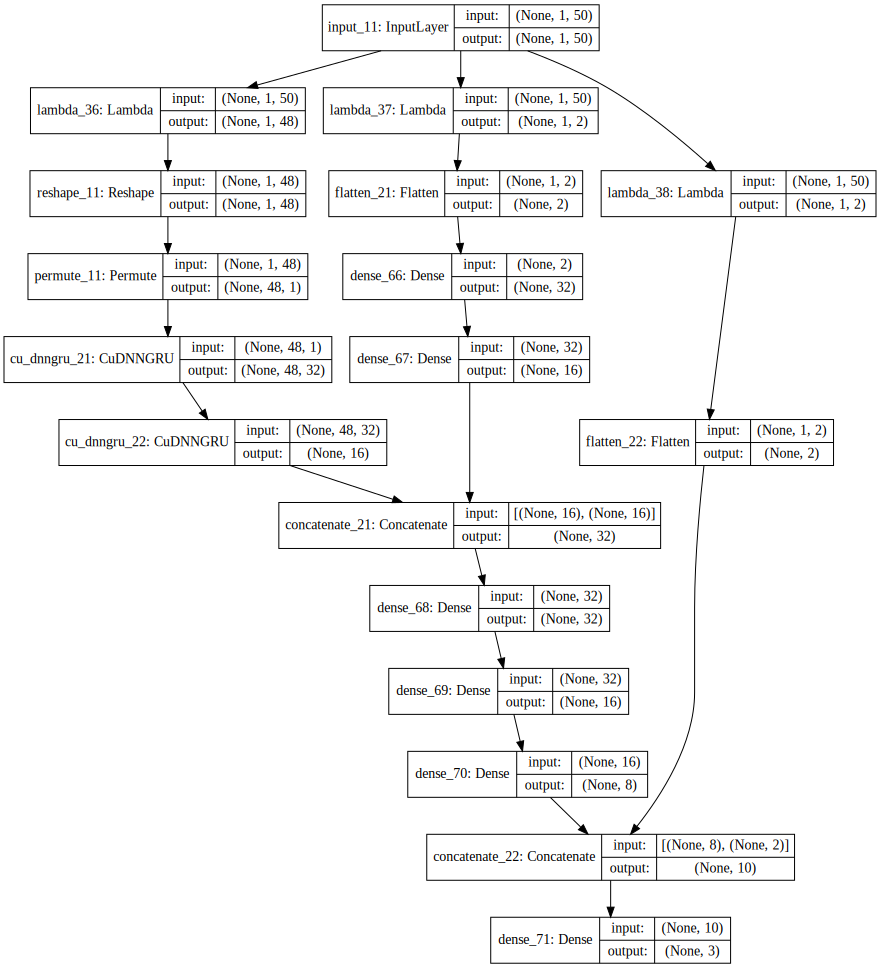

In [66]:
SVG(model_to_dot(drl.NN_model(),show_shapes=True).create(prog='dot', format='svg'))

test!


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:195: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


test!


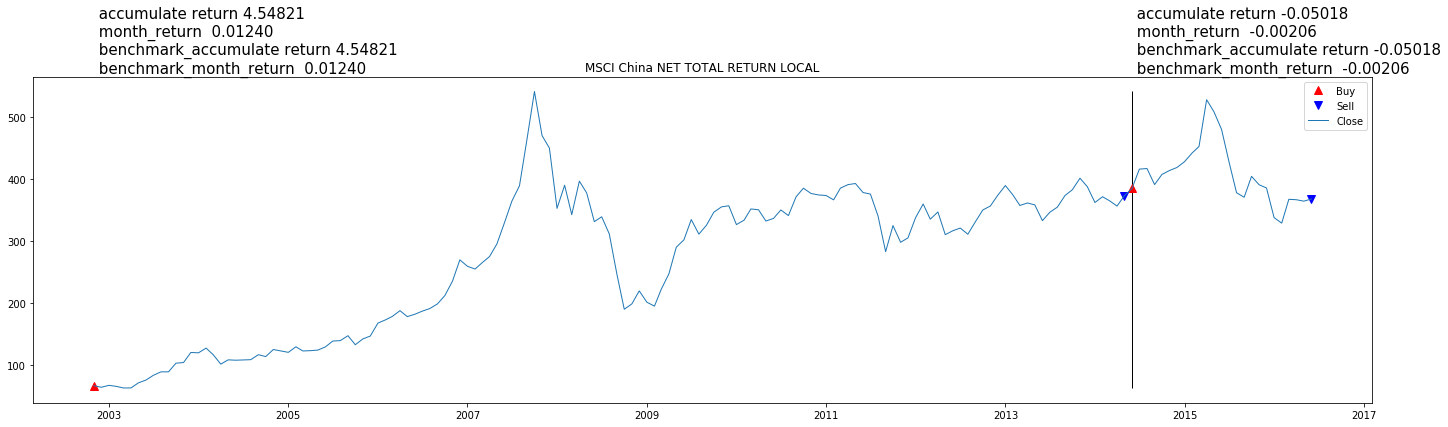

In [105]:
dqn.test(train_env_month, nb_episodes=1, visualize=False)
plot_data_train = train_data_month.loc[(HISTORY_LENGTH-1):\
                                ,['tx_month',INDEX_NM]].iloc[:-6,:].sort_values('tx_month')\
                               .reset_index(drop=True)
plot_data_train['action_list'] = train_env_month._params['history_action'] + [train_env_month._actions.get('sell')]
plot_data_train['accumulate_return_list'] = train_env_month._params['accumulate_return_list'] + [np.nan]
plot_data_train['reward_list'] = train_env_month._params['reward_list'] + [np.nan]
plot_data_train['hold_sell_list'] = train_env_month._params['hold_sell_list'] + [np.nan]
plot_data_train['over_buy_price_list'] = train_env_month._params['over_buy_price_list'] + [np.nan]
q_values_train_table = pd.DataFrame(dqn.history_q_values)[:-1]
plot_data_train = pd.concat([plot_data_train,q_values_train_table],axis=1)

dqn.test(test_env_month, nb_episodes=1, visualize=False)
plot_data_test = test_data_month.loc[(test_data_month.tx_month>=START_PRE_DATE)&(test_data_month.tx_month<=END_PRE_DATE)\
                                ,['tx_month',INDEX_NM]].sort_values('tx_month')\
                               .reset_index(drop=True)
plot_data_test['action_list'] = test_env_month._params['history_action'] + [test_env_month._actions.get('sell')] 
plot_data_test['accumulate_return_list'] = test_env_month._params['accumulate_return_list'] + [np.nan]
plot_data_test['reward_list'] = test_env_month._params['reward_list'] + [np.nan]
plot_data_test['hold_sell_list'] = test_env_month._params['hold_sell_list'] + [np.nan]
plot_data_test['over_buy_price_list'] = test_env_month._params['over_buy_price_list'] + [np.nan]
q_values_test_table = pd.DataFrame(dqn.history_q_values)[:-1]
plot_data_test = pd.concat([plot_data_test,q_values_test_table],axis=1)

plot_data = pd.concat([plot_data_train,plot_data_test]).rename(columns={test_env_month._actions.get('buy'):'buy',
                                                                        test_env_month._actions.get('sell'):'sell',
                                                                       test_env_month._actions.get('hold'):'hold'})
plot_data=plot_data.set_index('tx_month')
# action_list = test_env_month._history_action + [test_env_month._actions.get('sell')]
action_list = plot_data.action_list

plt.figure(figsize=(24,6))
plt.title(INDEX_NM)
# for i in range(len(sell_plot_locat)):
#     plt.text(sell_plot_locat[i], sell_plot_value[i], 'accumulate return \n    %0.5f'%(R[i]), fontsize=15)
plt.plot(plot_data.loc[plot_data.action_list==test_env_month._actions.get('buy'),[INDEX_NM]], 'r^',markersize=8, label='Buy')
plt.plot(plot_data.loc[plot_data.action_list==test_env_month._actions.get('sell'),[INDEX_NM]], 'bv',markersize=8, label='Sell')
plt.plot(plot_data.loc[:,INDEX_NM], label='Close')
month_return_test = accumulate_return_to_month(len(plot_data_test),test_env_month._params['accumulate_return'])
month_return_benchmark_test = accumulate_return_to_month(len(plot_data_test),test_env_month._params['benchmark_accumulate_return'])
month_return_train = accumulate_return_to_month(len(plot_data_train),train_env_month._params['accumulate_return'])
month_return_benchmark_train = accumulate_return_to_month(len(plot_data_train),train_env_month._params['benchmark_accumulate_return'])

plt.legend()
plt.vlines(START_PRE_DATE, plot_data.loc[:,INDEX_NM].min(), plot_data.loc[:,INDEX_NM].max())
plt.text(plot_data.index[0], plot_data.loc[:,INDEX_NM].max(),\
         ' accumulate return %0.5f\n month_return  %0.5f\n benchmark_accumulate return %0.5f\n benchmark_month_return  %0.5f\n'\
         %(train_env_month._params['accumulate_return'],month_return_train,\
           train_env_month._params['benchmark_accumulate_return'],month_return_benchmark_train), fontsize=15)
plt.text(START_PRE_DATE, plot_data.loc[:,INDEX_NM].max(),\
         ' accumulate return %0.5f\n month_return  %0.5f\n benchmark_accumulate return %0.5f\n benchmark_month_return  %0.5f\n'\
         %(test_env_month._params['accumulate_return'],month_return_test,\
           test_env_month._params['benchmark_accumulate_return'],month_return_benchmark_test,), fontsize=15)
plt.show()

In [ ]:
len(train_env_month._params['history_action'] )

In [ ]:
len(plot_data_train)

In [ ]:
# plot_data.to_csv('plot_data.csv')

In [ ]:
# plt.figure(figsize=(24,6))
# plt.plot(plot_data.loc[:,'buy'],label='buy', color='r')
# plt.plot(plot_data.loc[:,'hold'],label='hold', color='b')
# plt.plot(plot_data.loc[:,'sell'],label='sell',color='g')
# plt.vlines(START_PRE_DATE, plot_data.loc[:,['buy','hold','sell']].min().min(), \
#            plot_data.loc[:,['buy','hold','sell']].max().max())
# plt.legend()
# plt.show()

In [ ]:
# plt.figure(figsize=(24,6))
# plt.plot(plot_data.loc[:,'reward_list'],label='reward')
# plt.legend()
# plt.show()

In [ ]:
print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
check_data = []
for investment_month in [12,36,60,120]:
    data_start_index = 0
    more_data_len = 0
    if REWARD_STEP:
        more_data_len = max(REWARD_STEP) + HISTORY_LENGTH + investment_month-1
    else :
        more_data_len = HISTORY_LENGTH + investment_month-1

    no_time_var_list = []
    var_list = [NN_INPUT_COL]
    # var_list=name_list
    TIME_VAR = len(var_list)
    TIME_DATA_LENGTH = HISTORY_LENGTH*TIME_VAR
    NOT_TIME_DATA_LENGTH = 2 +len(no_time_var_list)
    data_list_col = np.unique(var_list+no_time_var_list+[REWARD_COL]+[PRICE_COL]).tolist()
    SS=StandardScaler()
    SS.fit(train_data_month.loc[:,[NN_INPUT_COL]])

    while data_start_index + more_data_len < len(train_data_month):
        check_data.append( train_data_month.loc[data_start_index:(data_start_index + more_data_len),data_list_col].reset_index(drop=True))
        data_start_index += 1 
params={'reward_step':[1], 'data_nor':False, 'trend_months':None, 'trend_noise':None, 'threshold':0,
        'min_buy_position':1,'cash_raise':1000,'cash_start':3000, 'max_position':float('inf'), 'episode_length':1000,
        'trading_fee':0, 'time_fee':0, 'history_length':12,'StandardScaler_list':None,'train_lab':False,
        'data_list':check_data,
        'trading_fee':TRADING_FEE,
        'time_fee':TIME_FEE,
        'history_length':HISTORY_LENGTH,
        'episode_length':EPISODE_LENGTH, 
        'min_buy_position':MIN_BUY_POSITION,
        'max_position':MAX_POSITION,
        'reward_col':REWARD_COL,
        'data_nor':DATA_NOR,
        'reward_step':REWARD_STEP,
        'reward_gamma':REWARD_GAMMA,
        'train_lab':RANDOM_TRAIN,
        'price_col':PRICE_COL,   
        'time_var_nm' : var_list,
        'no_time_var_nm' : no_time_var_list,
        'StandardScaler_list' : [SS]*len(check_data),
        'nn_input_col': [NN_INPUT_COL],
        'reward_scale' : REWARD_SCALE
       }
params['train_lab'] =False
train_env_month = SpreadTrading(params)

drl=DRL(history_length=HISTORY_LENGTH, time_var=TIME_VAR, time_data_length=TIME_DATA_LENGTH, 
        not_time_data_length=NOT_TIME_DATA_LENGTH, nb_actions=NB_ACTIONS
       )
step=1
dqn=drl.RL_method(env=train_env_month,check_env=train_env_month, step=step
                  , memory_length=MEMORY_LENGTH,train_interval=TRAIN_INTERVAL,\
                  policy=POLICY, nb_steps_warmup=NB_STEPS_WARMUP,\
                  alpha=MEMORY_ALPHA,beta=MEMORY_BETA,beta_annealed=MEMORY_ANNEALED\
                  , batch_size=BATCH_SIZE, gamma=GAMMA, target_model_update=TARGET_MODEL_UPDATE)
dqn.model.load_weights('h5/'+INDEX_NM+load_nm+'.h5')

dqn.test(train_env_month,filepath='h5/'+INDEX_NM+load_nm+'train.csv',\
         nb_episodes=len(check_data), visualize=False)
print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 

In [ ]:
print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
check_data = []
for investment_month in [12,36,60,120]:
    data_start_index = 0
    more_data_len = 0
    if REWARD_STEP:
        more_data_len = max(REWARD_STEP) + HISTORY_LENGTH + investment_month-1
    else :
        more_data_len = HISTORY_LENGTH + investment_month-1

    no_time_var_list = []
    var_list=[PRICE_COL]
    TIME_VAR = len(var_list)
    TIME_DATA_LENGTH = HISTORY_LENGTH*TIME_VAR
    data_list_col = np.unique(var_list+no_time_var_list+[REWARD_COL]+[NN_INPUT_COL]).tolist()
    SS=StandardScaler()
    SS.fit(train_data_month.loc[:,[NN_INPUT_COL]])

    while data_start_index + more_data_len < len(test_data_month):
        check_data.append( test_data_month.loc[data_start_index:(data_start_index + more_data_len),data_list_col].reset_index(drop=True))
        data_start_index += 1 
params={'reward_step':[1], 'data_nor':False, 'trend_months':None, 'trend_noise':None, 'threshold':0,
        'min_buy_position':1,'cash_raise':1000,'cash_start':3000, 'max_position':float('inf'), 'episode_length':1000,
        'trading_fee':0, 'time_fee':0, 'history_length':12,'StandardScaler_list':None,'train_lab':False,
        'data_list':check_data,
        'trading_fee':TRADING_FEE,
        'time_fee':TIME_FEE,
        'history_length':HISTORY_LENGTH,
        'episode_length':EPISODE_LENGTH, 
        'min_buy_position':MIN_BUY_POSITION,
        'max_position':MAX_POSITION,
        'reward_col':REWARD_COL,
        'data_nor':DATA_NOR,
        'reward_step':REWARD_STEP,
        'reward_gamma':REWARD_GAMMA,
        'train_lab':RANDOM_TRAIN,
        'price_col':PRICE_COL,   
        'time_var_nm' : var_list,
        'no_time_var_nm' : no_time_var_list,
        'StandardScaler_list' : [SS]*len(check_data),
        'nn_input_col': [NN_INPUT_COL],
        'reward_scale' : REWARD_SCALE
       }
params['train_lab'] =False
test_env_month = SpreadTrading(params)

drl=DRL(history_length=HISTORY_LENGTH, time_var=TIME_VAR, time_data_length=TIME_DATA_LENGTH, 
        not_time_data_length=NOT_TIME_DATA_LENGTH, nb_actions=NB_ACTIONS
       )
step=1
dqn=drl.RL_method(env=test_env_month,check_env=test_env_month, step=step
                  , memory_length=MEMORY_LENGTH,train_interval=TRAIN_INTERVAL,\
                  policy=POLICY, nb_steps_warmup=NB_STEPS_WARMUP,\
                  alpha=MEMORY_ALPHA,beta=MEMORY_BETA,beta_annealed=MEMORY_ANNEALED\
                  , batch_size=BATCH_SIZE, gamma=GAMMA, target_model_update=TARGET_MODEL_UPDATE)
dqn.model.load_weights('h5/'+INDEX_NM+load_nm+'.h5')

dqn.test(test_env_month,filepath='h5/'+INDEX_NM+load_nm+'test.csv',\
         nb_episodes=len(check_data), visualize=False)
print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 

In [ ]:

drl.NN_model().summary()